In [1]:
import numpy as np
# %matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.linear_model

In [2]:
np.random.seed(2)

## Toy Data

We create data with polynomial of order $P_{GT}$ + cosine + sine + noise

The sine and cosine actually play very little role.

In [3]:
## make up some random polynomial coefficients
def groundTruthPoly_coeffs(deg, D):
    coeffs = np.random.random( (deg+1,D))-0.5
    # coeffs[0,1] = 0
    # coeffs[2,1] = 0
    # coeffs[3,0] = 0    
    for d in range(D):
        coeffs[:,d] /= np.arange(1,deg+2)
    return coeffs

In [4]:
## make up a (noisy) y=f(X) ground truth relationship
def groundTruthPoly(coeffs, X, noise):
    N = X.shape[0]
    y = np.zeros(N)
    P = coeffs.shape[0]
    for p in range(P):
        y += np.dot(X**p,c[p])
    y += np.sin(X[:,0]**2) +np.cos(X[:,0])  
    y+= np.random.normal(0,noise, y.shape)
    return y

In [5]:
## simple case where visualization is possible: D=2
D = 1
np.random.seed(40)

## ground truth 
PGT = 3 # degree of ground truth polynom
c = groundTruthPoly_coeffs(PGT, D)

## regularization: very small
alpha = 0.0001

## (Over)-fitting

We use $N>P_{GT}$ data points, and then typically use a smaller polynomial order than number of points (otherwise there are multiple solutions)

We have a lot of validation points, to get a robust estimate of the empirical validation error (or score)

We use a polynomial model of order $P$, with $P_{GT} < P<N$, typically $P=N-1$

In [6]:
N = 8
P = N-2
X = (np.random.random((N,D))-0.5)*50

In [7]:

## train set   
noise = 120
y = groundTruthPoly(c, X, noise)

## validation set
Nval=500
Xval = (np.random.random((Nval,D))-0.5)*50
yval = groundTruthPoly(c, Xval, noise)

## model (polynomial)
polyFeatures = sklearn.preprocessing.PolynomialFeatures(P)
polyFeatures.fit(X)
Xt = polyFeatures.transform(X)
Xt_val = polyFeatures.transform(Xval)

reg = sklearn.linear_model.LinearRegression()
reg.fit(Xt,y)

ridgeReg = sklearn.linear_model.Ridge(alpha=alpha, solver='lsqr')
ridgeReg.fit(Xt,y)

print("NP_GT=",PGT, "N=", N, "Pmodel=",P, \
       "\ncoeffs. summed=","%.e"%np.abs(reg.coef_).sum(), "%.e"%reg.score(Xt_val, yval) \
      ,"\nregul. coeffs.=", "%.e"% np.abs(ridgeReg.coef_).sum(), "%.e"%ridgeReg.score(Xt_val, yval)) # , np.abs(reg.coef_)/c )


print("GT:", c ,"\nAll the Regression coefficients:",reg.coef_, "\nAll the Ridge Regression coefficients:", ridgeReg.coef_)


NP_GT= 3 N= 8 Pmodel= 6 
coeffs. summed= 6e+01 -7e+00 
regul. coeffs.= 9e-04 -9e+01
GT: [[-0.09231297]
 [-0.22231698]
 [ 0.09617829]
 [-0.0531737 ]] 
All the Regression coefficients: [ 0.00000000e+00 -4.77702976e+01  7.42068948e+00  5.06522773e-01
 -6.64122764e-02 -8.28071303e-04  9.33409202e-05] 
All the Ridge Regression coefficients: [ 0.00000000e+00 -6.68846759e-08 -2.55426987e-08 -7.23710241e-06
 -2.12828942e-05 -8.13413187e-04  3.02458204e-05]


### Remarks:

The (sum of the abolsute) **values of the coefficients** found with the *normal (not regularized) regression* are **much much bigger** in absolute value than those found by *regularized regression* (called **Ridge Regression**, for the L2 regularization).


### Plot
We now plot :
- the noiseless GT (not availble in real life !)
- the polynomial regression (without regul.)
- the polynomial regression (with regul.)
- a cloud of validation points, to get an idea of the noise in the GT
- the (few) training points, that were used to fit the model


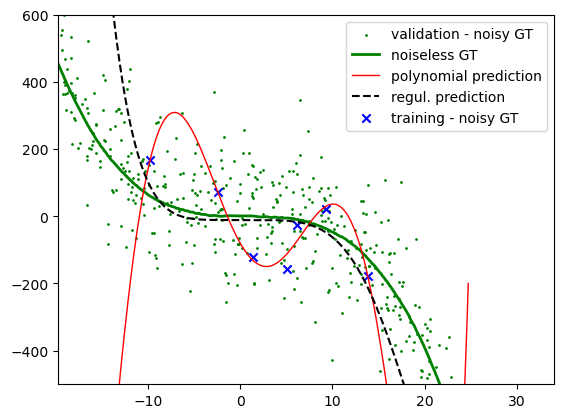

In [8]:
plt.figure()
prediction = reg.predict(polyFeatures.transform(Xval))
prediction_regularized  = ridgeReg.predict(polyFeatures.transform(Xval))
noiseless_GT = groundTruthPoly(c, Xval, 0 )
arg = np.argsort(Xval[:,0])

plt.scatter(Xval[:,0], yval, label="validation - noisy GT", color="green", s=1)
plt.plot(Xval[:,0][arg], noiseless_GT[arg], ls="-", label="noiseless GT", lw=2, color="green")
plt.plot(Xval[:,0][arg], prediction[arg], lw=1,label="polynomial prediction", color="red")
plt.plot(Xval[:,0][arg], prediction_regularized[arg], ls="--", label="regul. prediction", color="black")
plt.scatter(X[:,0], y, label="training - noisy GT", marker='x',color= "blue", s=35)
plt.legend()
plt.ylim([-500,600])
plt.xlim([X.min()-10, X.max()+10])
plt.savefig("overfitting-large coeffs.svg")

### More playing around

if we want to play around with $N, P$, we may enclose this in a function, and try many things

In [9]:

def experiment(c, X, N, P, seed):
    ## train set   
    noise = 120
    y = groundTruthPoly(c, X, noise)

    ## validation set
    Nval=150
    Xval = (np.random.random((Nval,D))-0.5)*50
    yval = groundTruthPoly(c, Xval, noise)

    ## model (polynomial)
    polyFeatures = sklearn.preprocessing.PolynomialFeatures(P)
    polyFeatures.fit(X)
    Xt = polyFeatures.transform(X)
    Xt_val = polyFeatures.transform(Xval)

    reg = sklearn.linear_model.LinearRegression()
    reg.fit(Xt,y)
    
    ridgeReg = sklearn.linear_model.Ridge(alpha=alpha, solver='lsqr')
    ridgeReg.fit(Xt,y)

    scoreRaw         = reg.score(Xt_val, yval)
    scoreRegul = ridgeReg.score(Xt_val, yval)
    
#     print("NP_GT=",PGT, "N=", N, "Pmodel=",P, \
#        "\ncoeffs. summed=","%.e"%np.abs(reg.coef_).sum(), "%.e"%scoreRaw \
#       ,"\nregul. coeffs.=", "%.e"% np.abs(ridgeReg.coef_).sum(), "%f"%scoreRegul ) # , np.abs(reg.coef_)/c )

    return reg, ridgeReg, scoreRaw, scoreRegul

In [10]:
N, PGT

(8, 3)

### Variance of results

We repeat the same experiment (keeping the same $X$ inputs, but changing the realization of the noise in the true labels $y_{GT}$.

Our observations are robust.

In [11]:
# for N in range(2,PGT+6):
N = PGT+5

# for P in range(N-2,N+2):
P=N-2

Nexpe=50
rawRegressionCoeffsAmplitudes= np.zeros(Nexpe)
regRegressionCoeffsAmplitudes= np.zeros(Nexpe)
scoreRaw= np.zeros(Nexpe)
scoreRegul= np.zeros(Nexpe)

for seed in range(Nexpe):
    reg, ridgeReg, scoreRaw[seed], scoreRegul[seed] = experiment(c, X, N, P, seed)
    rawRegressionCoeffsAmplitudes[seed] = np.abs(reg.coef_).sum()
    regRegressionCoeffsAmplitudes[seed] = np.abs(ridgeReg.coef_).sum()

    #     print()

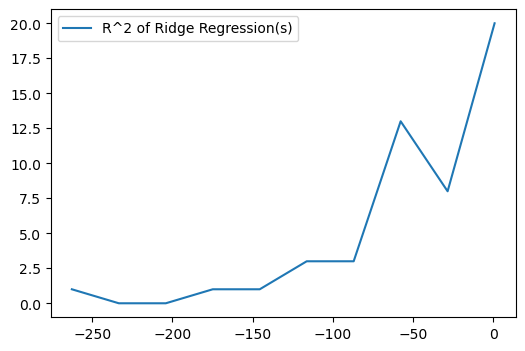

In [12]:
plt.figure(1,[6,4])
count, bins = np.histogram(scoreRegul)
plt.plot(bins[1:],count, label="R^2 of Ridge Regression(s)")
plt.legend()

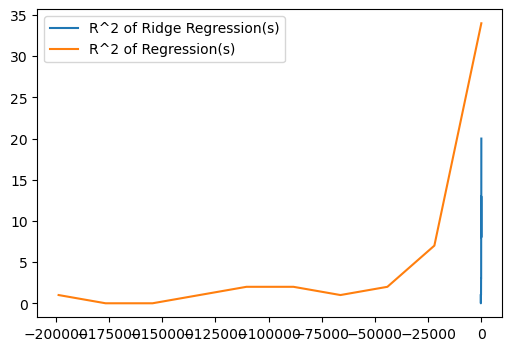

In [13]:
plt.figure(1,[6,4])
count, bins = np.histogram(scoreRegul)
plt.plot(bins[1:],count, label="R^2 of Ridge Regression(s)")
count, bins = np.histogram(scoreRaw)
plt.plot(bins[1:],count, label="R^2 of Regression(s)")
# plt.ylabel(r"$P(\sum_d |w_d| )$")
# plt.xlabel(r"  $\sum_d |w_d|$")
# plt.semilogx()
plt.legend()

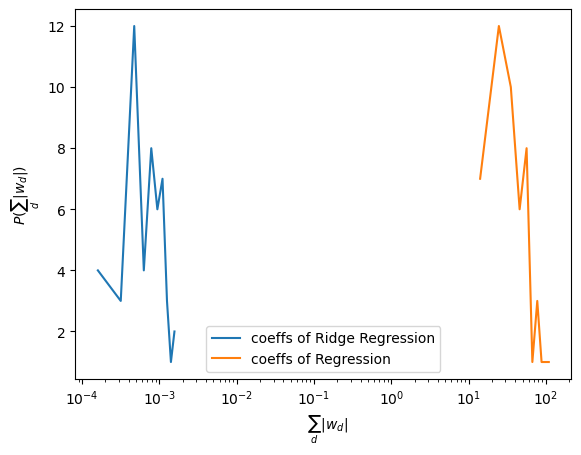

In [14]:
count, bins = np.histogram(regRegressionCoeffsAmplitudes)
plt.plot(bins[1:],count, label="coeffs of Ridge Regression")
count, bins = np.histogram(rawRegressionCoeffsAmplitudes)
plt.plot(bins[1:],count, label="coeffs of Regression")
plt.ylabel(r"$P(\sum_d |w_d| )$")
plt.xlabel(r"  $\sum_d |w_d|$")
plt.semilogx()
plt.legend()

### Variations with model complexity $P$

We now vary the order of the model, $P$.

In [15]:
# for N in range(2,PGT+6):
N = PGT+5


Nexpe=8
rawRegressionCoeffsAmplitudes= np.zeros(Nexpe)
regRegressionCoeffsAmplitudes= np.zeros(Nexpe)
scoreRaw= np.zeros(Nexpe)
scoreRegul= np.zeros(Nexpe)

i=0
Pvalues = np.arange(N-4,N+4)
for P in Pvalues:
    seed =1 
    reg, ridgeReg, scoreRaw[i], scoreRegul[i] = experiment(c, X, N, P, seed)
    rawRegressionCoeffsAmplitudes[i] = np.abs(reg.coef_).sum()
    regRegressionCoeffsAmplitudes[i] = np.abs(ridgeReg.coef_).sum()
    i+=1

Text(0.5, 0, 'order P of polynomial used as model (true=8)')

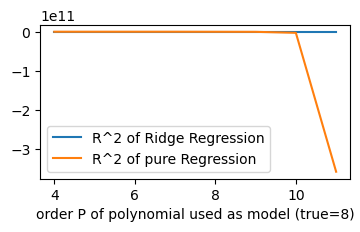

In [16]:
plt.figure(3, [4,2])
plt.plot(Pvalues, scoreRegul, label= "R^2 of Ridge Regression")
plt.plot(Pvalues, scoreRaw, label= "R^2 of pure Regression")
plt.legend()
plt.xlabel("order P of polynomial used as model (true=%i)"%(N))
# plt.semilogy()

[]

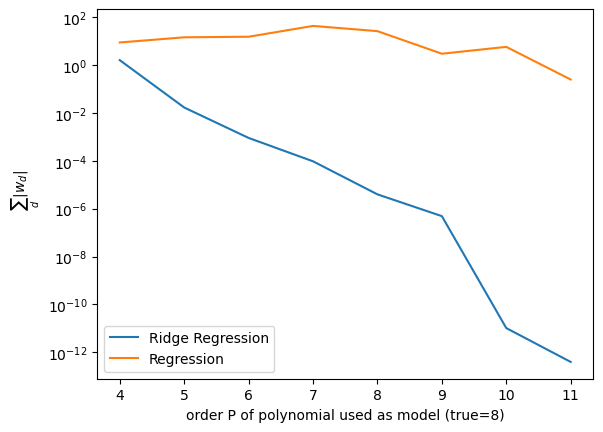

In [17]:
plt.plot(Pvalues, regRegressionCoeffsAmplitudes, label= "Ridge Regression")
plt.plot(Pvalues, rawRegressionCoeffsAmplitudes, label= "Regression")
plt.ylabel(r"  $\sum_d |w_d|$")
plt.xlabel("order P of polynomial used as model (true=%i)"%(N))
plt.legend()
plt.semilogy()

In [18]:
# # for N in range(2,PGT+6):
# N = PGT+5


# # Nexpe=20*8
# # rawRegressionCoeffsAmplitudes= np.zeros(Nexpe)
# # regRegressionCoeffsAmplitudes= np.zeros(Nexpe)
# # scoreRaw= np.zeros(Nexpe)
# # scoreRegul= np.zeros(Nexpe)

# Nexpe=20

# for P in range(N-4,N+4):

#     rawRegressionCoeffsAmplitudes= np.zeros(Nexpe)
#     regRegressionCoeffsAmplitudes= np.zeros(Nexpe)
#     scoreRaw= np.zeros(Nexpe)
#     scoreRegul= np.zeros(Nexpe)
    
#     i=0
#     for seed in range(1):
#         reg, ridgeReg, scoreRaw[i], scoreRegul[i] = experiment(c, X, N, P, seed)
#         i+=1


#     plt.figure(1,[6,4])
#     count, bins = np.histogram(scoreRegul)
#     plt.plot(bins[1:],count, label="P=%i, R^2 of Ridge Regression(s)"%(P))
#     count, bins = np.histogram(scoreRaw)
#     plt.plot(bins[1:],count, label="P=%i, R^2 of Regression(s)"%(P))
#     # plt.ylabel(r"$P(\sum_d |w_d| )$")
#     # plt.xlabel(r"  $\sum_d |w_d|$")
#     # plt.semilogx()
#     plt.legend()
        
    
#     plt.figure(2,[6,4])
#     count, bins = np.histogram(regRegressionCoeffsAmplitudes)
#     plt.plot(bins[1:],count, label="coeffs of Ridge Regression")
#     count, bins = np.histogram(rawRegressionCoeffsAmplitudes)
#     plt.plot(bins[1:],count, label="coeffs of Regression")
#     plt.ylabel(r"$P(\sum_d |w_d| )$")
#     plt.xlabel(r"  $\sum_d |w_d|$")
#     plt.semilogx()
#     plt.legend()


In [19]:
scoreRaw

array([ 5.47690051e-01, -2.11922848e+02, -3.06912360e+04, -1.34649225e+06,
       -1.24623016e+08, -2.90454213e+08, -2.79765446e+09, -3.57043946e+11])

## Observations:

- for small order $P$, $P \ll N$, the score is not too bad (still, the regularized model performs better than the non-regularized one). The value of coefficients is not too crazy (and not too much different between regul and un-regularized models, although still different by a factor of 100)
- in the non-regularized model, for very large orders $P\gg N$, the score is **very bad**. However, the value of the coefficients is again not so big ! **So, reality is not as simple as what we said initially** (when we said that "overfitting ≃ large weights").
-  in the regularized model, for very large orders $P\gg N$, the score is ok-ish. It's better for odd values of $P$. The value of the coefficients decreases with increasing order. This has to do with the fact that the  output, $y=\vec w .\vec \Phi(x)$, increases a lot with a small increase in $w_P$, when it's multiplied with $x^P$.